In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [2]:
# Download historical data
sp500_ticker = '^GSPC'
russell_ticker = '^RUT'
sp500_data = yf.download(sp500_ticker, start='2010-01-01', end='2020-12-31')
russell_data = yf.download(russell_ticker, start='2010-01-01', end='2020-12-31')

# Prepare the DataFrame
df = pd.DataFrame({
    'SP500_Close': sp500_data['Close'],
    'Russell_Close': russell_data['Close']
})
df['Price_Ratio'] = df['SP500_Close'] / df['Russell_Close']


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Price_Ratio'].values.reshape(-1,1))

def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(sequence_length, len(data)):
        x = data[i-sequence_length:i]
        y = data[i]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length and create sequences
sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and test sets
test_size = 0.2
train_size = int((1 - test_size) * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


In [14]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Prediction of the next closing value
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1, verbose=1)

# # Adjust the LSTM architecture
# model = Sequential()
# model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# model.add(Dropout(0.3))
# model.add(LSTM(units=100, return_sequences=True))
# model.add(Dropout(0.3))
# model.add(LSTM(units=100))
# model.add(Dropout(0.3))
# model.add(Dense(units=1))

# # Compile the model with a smaller learning rate
# from keras.optimizers import Adam
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# # Early stopping callback
# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Fit the model with callbacks
# history = model.fit(
#     X_train, y_train,
#     epochs=100,  # Set higher epochs with early stopping
#     batch_size=64,  # Try a different batch size
#     validation_split=0.1,
#     callbacks=[early_stopping],
#     verbose=1
# )


Epoch 1/25
61/61 [==============================] - 5s 49ms/step - loss: 0.0023 - val_loss: 5.2851e-04
Epoch 2/25
61/61 [==============================] - 2s 31ms/step - loss: 8.4329e-04 - val_loss: 4.4554e-04
Epoch 3/25
61/61 [==============================] - 2s 32ms/step - loss: 7.4707e-04 - val_loss: 2.9253e-04
Epoch 4/25
61/61 [==============================] - 2s 38ms/step - loss: 7.0366e-04 - val_loss: 3.2123e-04
Epoch 5/25
61/61 [==============================] - 3s 42ms/step - loss: 6.6024e-04 - val_loss: 2.5760e-04
Epoch 6/25
61/61 [==============================] - 2s 34ms/step - loss: 6.1207e-04 - val_loss: 4.3548e-04
Epoch 7/25
61/61 [==============================] - 2s 35ms/step - loss: 5.6876e-04 - val_loss: 2.3337e-04
Epoch 8/25
61/61 [==============================] - 2s 34ms/step - loss: 5.2450e-04 - val_loss: 2.3788e-04
Epoch 9/25
61/61 [==============================] - 3s 49ms/step - loss: 4.8671e-04 - val_loss: 2.2704e-04
Epoch 10/25
61/61 [======================

17/17 [==============================] - 1s 8ms/step


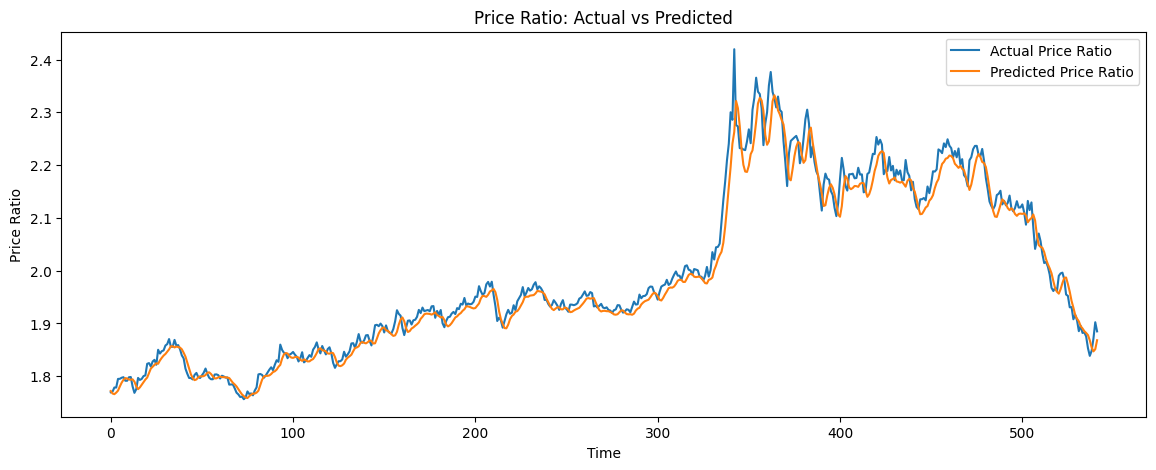

In [15]:
# Predict on the test set
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted prices
plt.figure(figsize=(14,5))
plt.plot(real_prices, label='Actual Price Ratio')
plt.plot(predicted_prices, label='Predicted Price Ratio')
plt.title('Price Ratio: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Price Ratio')
plt.legend()
plt.show()


In [22]:
# Prepare the signals DataFrame
signals_df = pd.DataFrame(index=df.index[train_size + sequence_length:])
signals_df['actual'] = real_prices.ravel()
signals_df['predicted'] = predicted_prices.ravel()
signals_df['rolling_std'] = signals_df['actual'].rolling(window=60).std()
std_multiplier = 1.0
signals_df['upper_threshold'] = signals_df['actual'] + (signals_df['rolling_std'] * std_multiplier)
signals_df['lower_threshold'] = signals_df['actual'] - (signals_df['rolling_std'] * std_multiplier)
signals_df['signal'] = 0
signals_df.loc[signals_df['predicted'] > signals_df['upper_threshold'], 'signal'] = -1
signals_df.loc[signals_df['predicted'] < signals_df['lower_threshold'], 'signal'] = 1
signals_df = signals_df[1:]  # Drop the first signal


In [27]:

# Initialize backtest variables
initial_capital = 100000
capital = initial_capital
risk_per_trade = 1000
stop_loss_level = 0.02

maximum_capital = 100000
# Initialize a DataFrame to hold the backtest results
backtest_results = pd.DataFrame(index=signals_df.index)
backtest_results['capital'] = initial_capital

# Simulate the trading strategy with stop-loss
for i in range(1, len(signals_df)):
    signal = signals_df['signal'].iloc[i]
    previous_signal = signals_df['signal'].iloc[i-1]
    if signal != 0 and signal != previous_signal:
        entry_price = signals_df['actual'].iloc[i]
        # Exit trade based on stop loss or change in signal
        for j in range(i+1, len(signals_df)):
            current_price = signals_df['actual'].iloc[j]
            price_change = (current_price - entry_price) / entry_price
            if (signal == 1 and price_change <= -stop_loss_level) or \
               (signal == -1 and price_change >= stop_loss_level) or \
               (signals_df['signal'].iloc[j] != signal):
                trade_result = -risk_per_trade if price_change > 0 else risk_per_trade
                capital += trade_result
                maximum_capital = max(maximum_capital, capital)
                break  # Exit the loop and the trade

    backtest_results.loc[signals_df.index[i], 'capital'] = capital

Total Return: 15.00%
Maximum Return: 18.00%


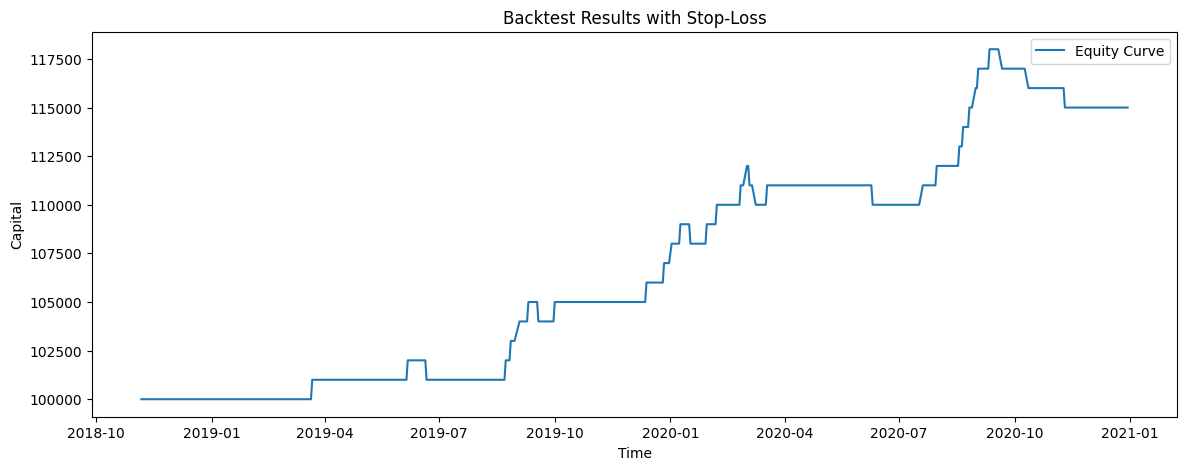

In [28]:
# Calculate and plot the final results
total_return = (capital - initial_capital) / initial_capital
print(f"Total Return: {total_return:.2%}")
maximum_return = (maximum_capital - initial_capital) / initial_capital
print(f"Maximum Return: {maximum_return:.2%}")
plt.figure(figsize=(14, 5))
plt.plot(backtest_results['capital'], label='Equity Curve')
plt.title('Backtest Results with Stop-Loss')
plt.xlabel('Time')
plt.ylabel('Capital')
plt.legend()
plt.show()